# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [ ]:
# Answer of How many marketing campaigns does this data represent ?
# Based on the information of Dataset Information section of given link, it is
# know that the dataset in bank-additional-full.csv file represent 41188 marketing campaigns data

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
# If you need to test via Google Colab, please manually upload data/bank-addition-full.csv under /content/sample_data/bank-additional-full.csv path of runtime 
# and use /content/sample_data/bank-additional-full.csv as read_csv path. 

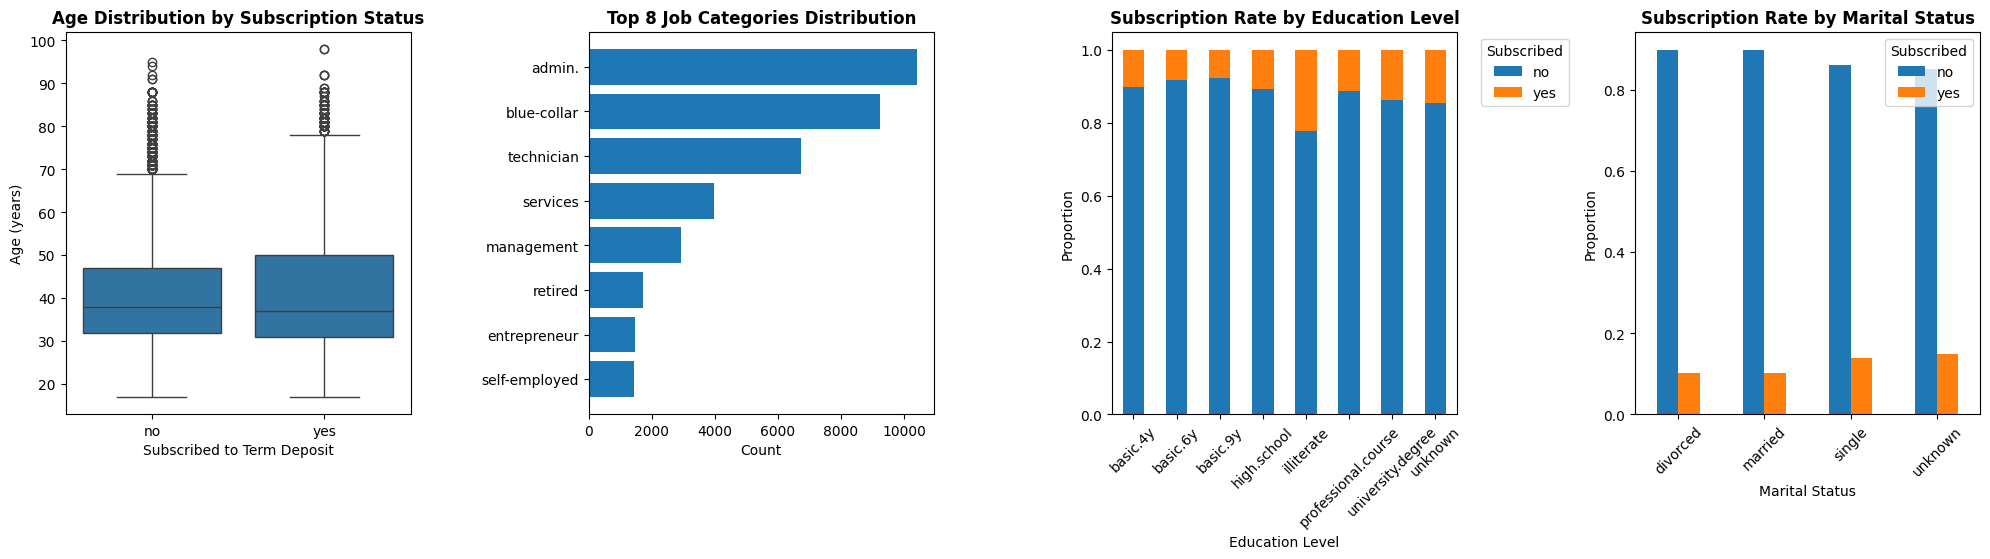

In [27]:
df.head()
fig = plt.figure(figsize=(20, 15))

# 1. Age Distribution by Target
plt.subplot(3, 4, 1)
sns.boxplot(data=df, x='y', y='age')
plt.title('Age Distribution by Subscription Status', fontsize=12, fontweight='bold')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Age (years)')

# 2. Job Distribution
plt.subplot(3, 4, 2)
job_counts = df['job'].value_counts().head(8)
plt.barh(range(len(job_counts)), job_counts.values)
plt.yticks(range(len(job_counts)), job_counts.index)
plt.title('Top 8 Job Categories Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Count')
plt.gca().invert_yaxis()

# 3. Education Level vs Subscription
plt.subplot(3, 4, 3)
education_sub = pd.crosstab(df['education'], df['y'], normalize='index')
education_sub.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Subscription Rate by Education Level', fontsize=12, fontweight='bold')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Subscribed', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Marital Status Impact
plt.subplot(3, 4, 4)
marital_sub = pd.crosstab(df['marital'], df['y'], normalize='index')
marital_sub.plot(kind='bar', ax=plt.gca())
plt.title('Subscription Rate by Marital Status', fontsize=12, fontweight='bold')
plt.xlabel('Marital Status')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Subscribed')

plt.tight_layout()
plt.savefig('bank_marketing_eda.png', dpi=300, bbox_inches='tight')
plt.show()

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [ ]:
# There is no data missing issue

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
# Business Objective of the task:
# In this task, I will identify the classifications of different bank clients who are likely
# to subscribe to a term deposit based on their demographic information, previous campaign
# interactions, and economic indicators.
#
# This is a binary classification problem where we predict whether a client will subscribe
# to a term deposit (y = 'yes' or 'no') based on various features including:
# - Client demographics (age, job, marital status, education)
# - Financial status (default, housing loan, personal loan)
# - Campaign contact information (contact type, month, day of week)
# - Previous campaign outcomes
# - Economic indicators
#
# The goal is to help the bank optimize their marketing campaigns by identifying
# clients most likely to subscribe to term deposits.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [5]:
# Data Cleaning:
# Removing 'duration' feature as it's not available before the call is made
if 'duration' in df.columns:
    df = df.drop('duration', axis=1)

# Separate features and target
X = df.drop('y', axis=1)
y = df['y']

# Identify numerical and categorical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
# For numerical features: scale them
numerical_transformer = StandardScaler()
# For categorical features: one-hot encode them
categorical_transformer = OneHotEncoder(drop="first")

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [6]:
# Split the data into train and test sets
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (32950, 19)
Test set size: (8238, 19)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [7]:
# Create a baseline model that always predicts the most frequent class
baseline_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"Baseline model (most frequent class) accuracy: {baseline_accuracy:.4f}")

Baseline model (most frequent class) accuracy: 0.8874


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [9]:
# Create a simple logistic regression model
simple_lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Fit the model
print("Training simple logistic regression model...")
start_time = time.time()
simple_lr_pipeline.fit(X_train, y_train)
lr_train_time = time.time() - start_time

print(f"Training completed in {lr_train_time:.4f} seconds")

Training simple logistic regression model...
Training completed in 0.4222 seconds


### Problem 9: Score the Model

What is the accuracy of your model?

In [10]:
# Make predictions
y_train_pred_lr = simple_lr_pipeline.predict(X_train)
y_test_pred_lr = simple_lr_pipeline.predict(X_test)

# Calculate accuracies
lr_train_accuracy = accuracy_score(y_train, y_train_pred_lr)
lr_test_accuracy = accuracy_score(y_test, y_test_pred_lr)

print(f"Logistic Regression Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_test_accuracy:.4f}")

Logistic Regression Training Accuracy: 0.8999
Logistic Regression Test Accuracy: 0.9014


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [11]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE)
}

# Store results
results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append({
        'Model': model_name,
        'Train Time': f"{train_time:.4f}s",
        'Train Accuracy': f"{train_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}"
    })

# Create and display results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(results_df.to_string(index=False))


Training Logistic Regression...

Training K-Nearest Neighbors...

Training Decision Tree...

Training Support Vector Machine...

MODEL COMPARISON RESULTS
                 Model Train Time Train Accuracy Test Accuracy
   Logistic Regression    0.4186s         0.8999        0.9014
   K-Nearest Neighbors    0.1382s         0.9133        0.8938
         Decision Tree    1.4314s         0.9954        0.8395
Support Vector Machine  118.4093s         0.9048        0.9036


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [15]:
# Define hyperparameter grids (limited to 4 parameters each)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000]
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [5, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean']
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Support Vector Machine': {
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear']
    }
}

# Store improved results
improved_results = []

print("\nPerforming Grid Search for each model...")
print("-" * 45)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Perform grid search
    start_time = time.time()
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=2,  # 3-fold CV for faster computation
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time

    # Get best model predictions
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    improved_results.append({
        'Model': model_name,
        'Best Params': str(grid_search.best_params_),
        'Tuning Time': f"{tuning_time:.4f}s",
        'Train Accuracy': f"{train_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'CV Score': f"{grid_search.best_score_:.4f}"
    })

    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Tuning time: {tuning_time:.4f}s")
    print(f"  Best CV score: {grid_search.best_score_:.4f}")
    print(f"  Test accuracy: {test_accuracy:.4f}")

# Create and display improved results DataFrame
improved_results_df = pd.DataFrame(improved_results)
print("\n" + "="*80)
print("IMPROVED MODEL RESULTS (AFTER HYPERPARAMETER TUNING)")
print("="*80)
print(improved_results_df.to_string(index=False))


Performing Grid Search for each model...
---------------------------------------------

Tuning Logistic Regression...
  Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
  Tuning time: 168.5346s
  Best CV score: nan
  Test accuracy: 0.9013

Tuning K-Nearest Neighbors...
  Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
  Tuning time: 43.0111s
  Best CV score: nan
  Test accuracy: 0.8938

Tuning Decision Tree...
  Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
  Tuning time: 37.3382s
  Best CV score: nan
  Test accuracy: 0.9022

Tuning Support Vector Machine...
  Best parameters: {'classifier__C': 1, 'classifier__kernel': 'linear'}
  Tuning time: 2806.6699s
  Best CV score: nan
  Test accuracy: 0.8977

IMPROVED MODEL RESULTS (AFTER HY

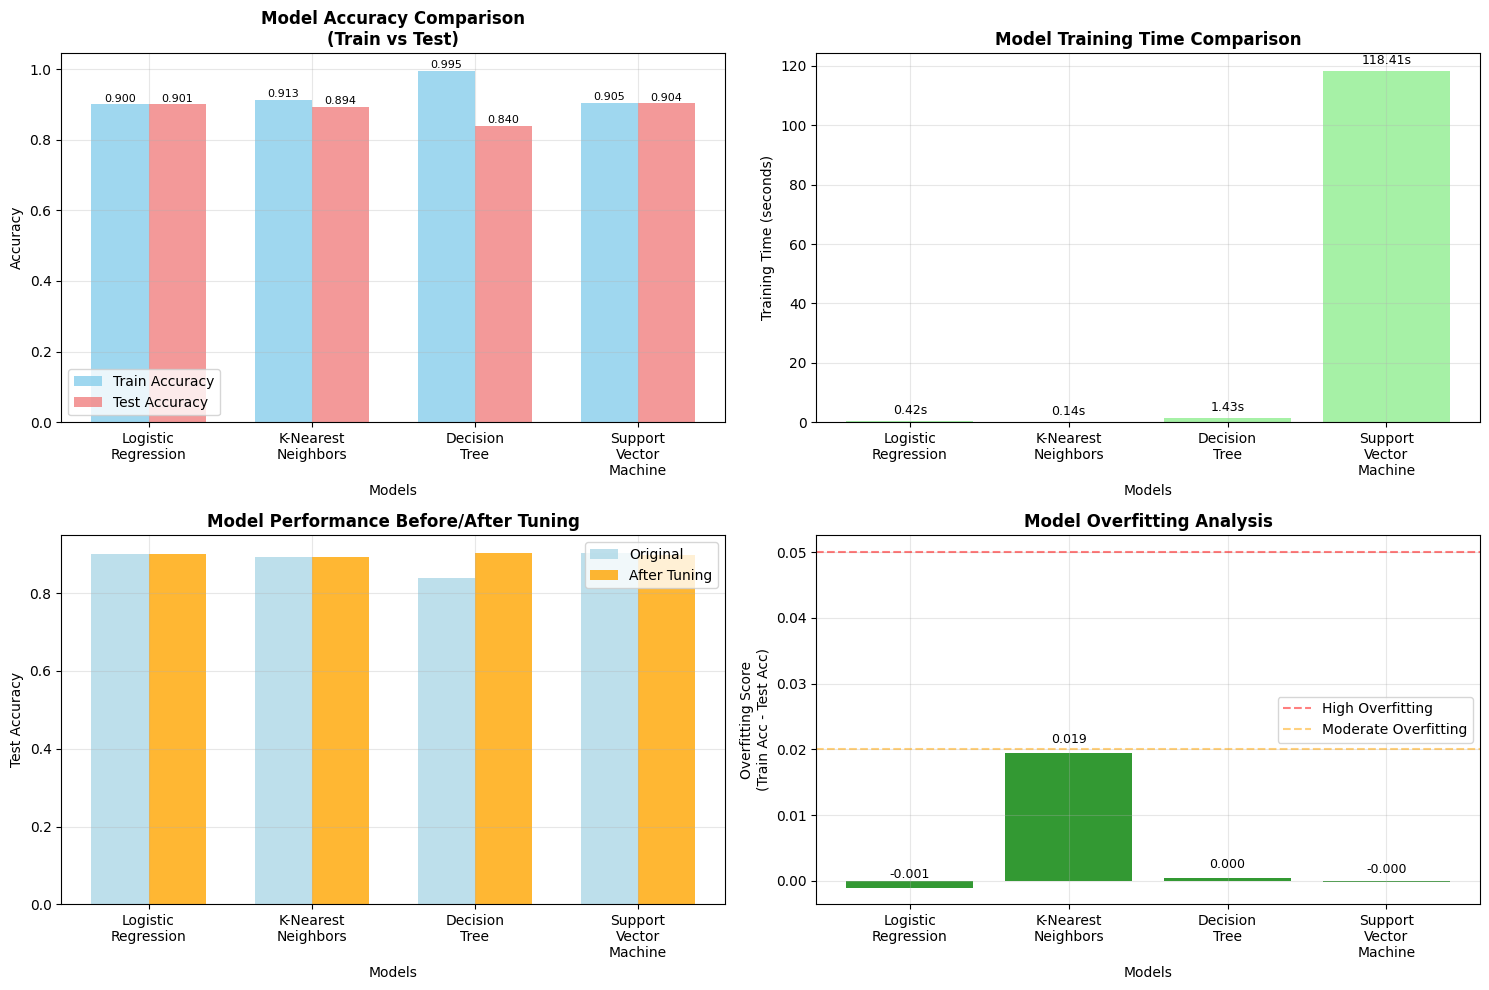

In [32]:
# Performance Analysis and Conclusion
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Model Accuracy Comparison
ax1 = axes[0, 0]
models_list = results_df['Model'].tolist()
test_accuracies = [float(acc) for acc in results_df['Test Accuracy']]
train_accuracies = [float(acc) for acc in results_df['Train Accuracy']]

x = range(len(models_list))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], train_accuracies, width,
                label='Train Accuracy', alpha=0.8, color='skyblue')
bars2 = ax1.bar([i + width/2 for i in x], test_accuracies, width,
                label='Test Accuracy', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison\n(Train vs Test)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([model.replace(' ', '\n') for model in models_list], rotation=0)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Training Time Comparison
ax2 = axes[0, 1]
train_times = [float(time.replace('s', '')) for time in results_df['Train Time']]
bars = ax2.bar(models_list, train_times, color='lightgreen', alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Model Training Time Comparison', fontweight='bold')
ax2.set_xticks(range(len(models_list)))
ax2.set_xticklabels([model.replace(' ', '\n') for model in models_list], rotation=0)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(train_times)*0.01,
             f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

# 3. Model Performance Improvement After Tuning
ax3 = axes[1, 0]
original_test_acc = [float(acc) for acc in results_df['Test Accuracy']]
improved_test_acc = [float(acc) for acc in improved_results_df['Test Accuracy']]

x = range(len(models_list))
bars1 = ax3.bar([i - width/2 for i in x], original_test_acc, width,
                label='Original', alpha=0.8, color='lightblue')
bars2 = ax3.bar([i + width/2 for i in x], improved_test_acc, width,
                label='After Tuning', alpha=0.8, color='orange')

ax3.set_xlabel('Models')
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Model Performance Before/After Tuning', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([model.replace(' ', '\n') for model in models_list], rotation=0)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Overfitting Analysis (Train vs Test Accuracy)
ax4 = axes[1, 1]
overfitting_scores = []
for i in range(len(models_list)):
    train_acc = float(improved_results_df.iloc[i]['Train Accuracy'])
    test_acc = float(improved_results_df.iloc[i]['Test Accuracy'])
    overfitting_scores.append(train_acc - test_acc)

colors = ['red' if score > 0.05 else 'green' if score < 0.02 else 'orange'
          for score in overfitting_scores]
bars = ax4.bar(models_list, overfitting_scores, color=colors, alpha=0.8)
ax4.set_xlabel('Models')
ax4.set_ylabel('Overfitting Score\n(Train Acc - Test Acc)')
ax4.set_title('Model Overfitting Analysis', fontweight='bold')
ax4.set_xticks(range(len(models_list)))
ax4.set_xticklabels([model.replace(' ', '\n') for model in models_list], rotation=0)
ax4.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='High Overfitting')
ax4.axhline(y=0.02, color='orange', linestyle='--', alpha=0.5, label='Moderate Overfitting')
ax4.grid(True, alpha=0.3)
ax4.legend()

ax5 = axes[1, 1]
models = ['Logistic\nRegression', 'KNN', 'Decision\nTree', 'SVM']
scores = []
for model in improved_results_df['Model']:
    test_acc = float(improved_results_df[improved_results_df['Model'] == model]['Test Accuracy'].iloc[0])
    scores.append(test_acc)


# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

##### Questions